# Baselines

In [ ]:
# import the libraries
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# import and see train_data.csv
df_train_csv = dd.read_csv('Data/train_data.csv')
df_train_csv.head()

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# apply SN-filter
df_sn = df_train_csv[df_train_csv["SN_filter"]==1]

# split into 2A3 MaP and DMS MaP datasets
df_2A3 = df_sn[df_sn["experiment_type"]=="2A3_MaP"]
df_DMS = df_sn[df_sn["experiment_type"]=="DMS_MaP"]

# split into train and test
X_2A3 = df_2A3["sequence"]
y_2A3 = df_2A3.loc[:, df_2A3.columns.str.fullmatch("reactivity_\d\d\d\d")]
X_2A3_train, X_2A3_test, y_2A3_train, y_2A3_test = train_test_split(X_2A3, y_2A3, test_size=0.2, shuffle=True, blockwise=True, random_state=42)

X_DMS = df_DMS["sequence"]
y_DMS = df_DMS.loc[:, df_DMS.columns.str.fullmatch("reactivity_\d\d\d\d")]
X_DMS_train, X_DMS_test, y_DMS_train, y_DMS_test = train_test_split(X_DMS, y_DMS, test_size=0.2, shuffle=True, blockwise=True, random_state=42)

In [ ]:
# import and see train_sequences.csv
df_test_csv = dd.read_csv('Data/test_sequences.csv')
df_test_csv.head()

,id_min,id_max,sequence_id,sequence,future
0,0,176,eee73c1836bc,GGGAACGACUCGAGUAGAGUCGAAAAUUUCCUUCCAAAUCCUGAGG...,0
1,177,353,d2a929af7a97,GGGAACGACUCGAGUAGAGUCGAAAAUGUAAUCAGAUUGCUUCUCC...,0
2,354,530,d39a4425ff45,GGGAACGACUCGAGUAGAGUCGAAAAAACACAUGAAUUUGAGGGUU...,0
3,531,707,1fc41e92d553,GGGAACGACUCGAGUAGAGUCGAAAAUCAGAGCUGGCAAAUGGAUG...,0
4,708,884,1d0826fb892f,GGGAACGACUCGAGUAGAGUCGAAAAUUUGGUAUUUGAUGCAUUAA...,0


In [ ]:
# create mutate and map dataset
id1=269545321
id2=269724007
df_mmap = df_test_csv[(id1 <= df_test_csv["id_min"]) & (df_test_csv["id_max"] <= id2)]["sequence"].compute()
df_mmap.head()

318570    GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...
318571    GGGAACGACUCGAGUAGAGUCGAAAACGAGGGAAAAGUUAUCAGGC...
318572    GGGAACGACUCGAGUAGAGUCGAAAAGCAGGGAAAAGUUAUCAGGC...
318573    GGGAACGACUCGAGUAGAGUCGAAAAGGUGGGAAAAGUUAUCAGGC...
318574    GGGAACGACUCGAGUAGAGUCGAAAAGGACGGAAAAGUUAUCAGGC...
Name: sequence, dtype: object

### Baseline 1.1

- Determine the average of all the reactivities in y_*_train

- Bound the average between 0 and 1

- Use the bounded average to predict all the reactivities in y_*_test

In [ ]:
# 2A3 MAE
avg_react = y_2A3_train.mean(axis=None).compute()
bnd_avg_react = max(min(1.0, avg_react), 0.0)
mean_absolute_error(y_2A3_test.clip(0, 1), bnd_avg_react)

0.31557867253726296

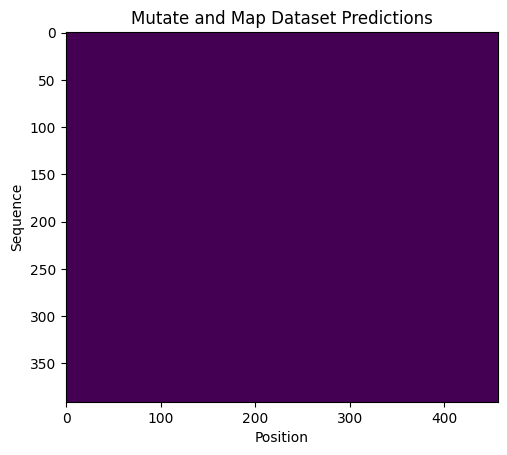

In [ ]:
# 2A3 MMAP
df_mmap_pred = df_mmap.str.split(pat="(?<=[AUGC])(?=[AUGC])", regex=True, expand=True)
df_mmap_pred.loc[:, :] = bnd_avg_react
df_mmap_pred = df_mmap_pred.astype("float")
plt.imshow(df_mmap_pred)
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

In [ ]:
# DMS MAE
avg_react = y_DMS_train.mean(axis=None).compute()
bnd_avg_react = max(min(1.0, avg_react), 0.0)
mean_absolute_error(y_DMS_test.clip(0, 1), bnd_avg_react)

0.31634920679730666

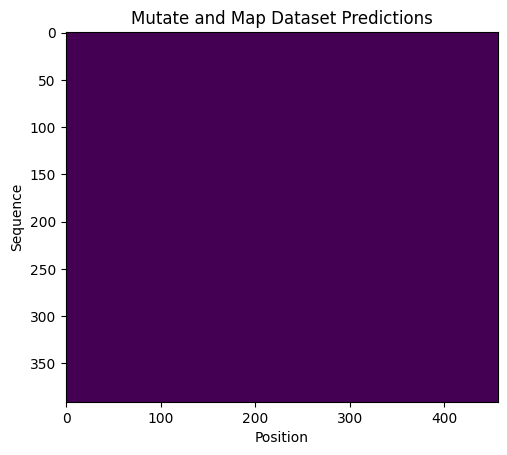

In [ ]:
# DMS MMAP
df_mmap_pred = df_mmap.str.split(pat="(?<=[AUGC])(?=[AUGC])", regex=True, expand=True)
df_mmap_pred.loc[:, :] = bnd_avg_react
df_mmap_pred = df_mmap_pred.astype("float")
plt.imshow(df_mmap_pred)
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

### Baseline 1.2

- Bound the reactivities in y_*_train between 0 and 1

- Determine the average of the bounded reactivities

- Use the average to predict all the reactivities in y_*_test

In [ ]:
# 2A3 MAE
avg_bnd_react = y_2A3_train.clip(0, 1).mean(axis=None).compute()
mean_absolute_error(y_2A3_test.clip(0, 1), avg_bnd_react)

0.2937536311675986

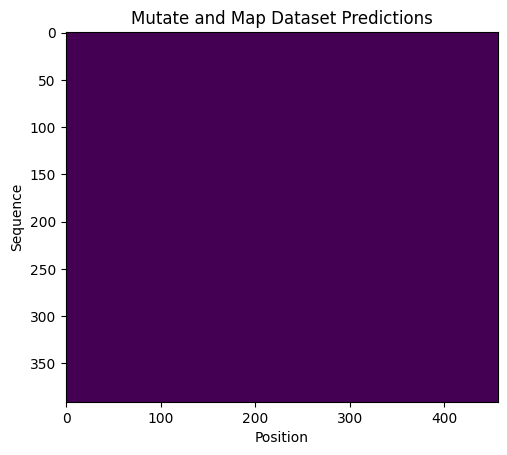

In [ ]:
# 2A3 MMAP
df_mmap_pred = df_mmap.str.split(pat="(?<=[AUGC])(?=[AUGC])", regex=True, expand=True)
df_mmap_pred.loc[:, :] = avg_bnd_react
df_mmap_pred = df_mmap_pred.astype("float")
plt.imshow(df_mmap_pred)
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

In [ ]:
# DMS
avg_bnd_react = y_DMS_train.clip(0, 1).mean(axis=None).compute()
mean_absolute_error(y_DMS_test.clip(0, 1), avg_bnd_react)

0.2969579877541066

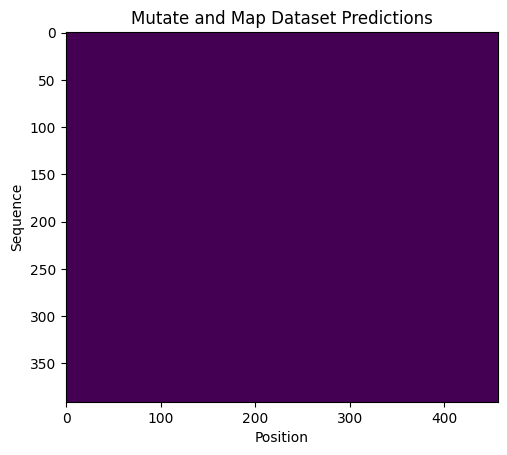

In [ ]:
# DMS MMAP
df_mmap_pred = df_mmap.str.split(pat="(?<=[AUGC])(?=[AUGC])", regex=True, expand=True)
df_mmap_pred.loc[:, :] = avg_bnd_react
df_mmap_pred = df_mmap_pred.astype("float")
plt.imshow(df_mmap_pred)
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

### Baseline 2.1

- For A, U, G, and C, determine the average of all the reactivities in y_*_train for the base

- Bound the averages between 0 and 1

- Use the four bounded averages to predict all the reactivities in y_*_test

In [ ]:
# 2A3 MAE
seq_mat_train = X_2A3_train.\
str.pad(width=206, side="right", fillchar="N").\
str.split(pat="(?<=[AUGCN])(?=[AUGCN])", n=205, expand=True)
seq_mat_train.columns = y_2A3_train.columns

avg_react_A = y_2A3_train[seq_mat_train=="A"].mean(axis=None).compute()
avg_react_U = y_2A3_train[seq_mat_train=="U"].mean(axis=None).compute()
avg_react_G = y_2A3_train[seq_mat_train=="G"].mean(axis=None).compute()
avg_react_C = y_2A3_train[seq_mat_train=="C"].mean(axis=None).compute()

seq_mat_test = X_2A3_test.\
str.pad(width=206, side="right", fillchar="N").\
str.split(pat="(?<=[AUGCN])(?=[AUGCN])", n=205, expand=True)
seq_mat_test.columns = y_2A3_test.columns

avg_react_AUGC = seq_mat_test
avg_react_AUGC[seq_mat_test=="A"] = avg_react_A
avg_react_AUGC[seq_mat_test=="U"] = avg_react_U
avg_react_AUGC[seq_mat_test=="G"] = avg_react_G
avg_react_AUGC[seq_mat_test=="C"] = avg_react_C
avg_react_AUGC[seq_mat_test=="N"] = np.nan
avg_react_AUGC = avg_react_AUGC.astype("float")

mean_absolute_error(y_2A3_test.clip(0, 1), avg_react_AUGC.clip(0, 1))

0.29895982416116446

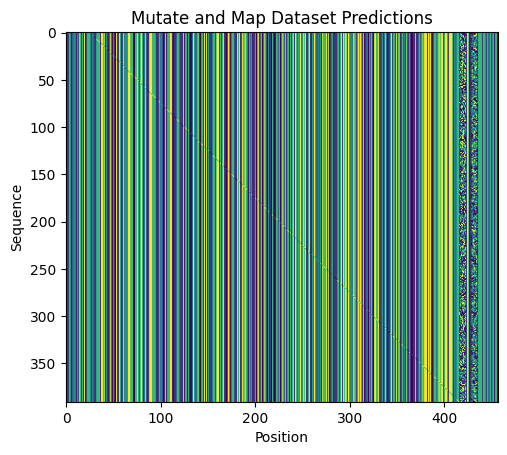

In [ ]:
# 2A3 MMAP
df_mmap_pred = df_mmap.str.split(pat="(?<=[AUGC])(?=[AUGC])", regex=True, expand=True)
df_mmap_pred[df_mmap_pred == "A"] = avg_react_A
df_mmap_pred[df_mmap_pred == "U"] = avg_react_U
df_mmap_pred[df_mmap_pred == "G"] = avg_react_G
df_mmap_pred[df_mmap_pred == "C"] = avg_react_C
df_mmap_pred = df_mmap_pred.clip(0, 1).astype("float")
plt.imshow(df_mmap_pred)
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

In [ ]:
# DMS
seq_mat_train = X_DMS_train.\
str.pad(width=206, side="right", fillchar="N").\
str.split(pat="(?<=[AUGCN])(?=[AUGCN])", n=205, expand=True)
seq_mat_train.columns = y_DMS_train.columns

avg_react_A = y_DMS_train[seq_mat_train=="A"].mean(axis=None).compute()
avg_react_U = y_DMS_train[seq_mat_train=="U"].mean(axis=None).compute()
avg_react_G = y_DMS_train[seq_mat_train=="G"].mean(axis=None).compute()
avg_react_C = y_DMS_train[seq_mat_train=="C"].mean(axis=None).compute()

seq_mat_test = X_DMS_test.\
str.pad(width=206, side="right", fillchar="N").\
str.split(pat="(?<=[AUGCN])(?=[AUGCN])", n=205, expand=True)
seq_mat_test.columns = y_DMS_test.columns

avg_react_AUGC = seq_mat_test
avg_react_AUGC[seq_mat_test=="A"] = avg_react_A
avg_react_AUGC[seq_mat_test=="U"] = avg_react_U
avg_react_AUGC[seq_mat_test=="G"] = avg_react_G
avg_react_AUGC[seq_mat_test=="C"] = avg_react_C
avg_react_AUGC[seq_mat_test=="N"] = np.nan
avg_react_AUGC = avg_react_AUGC.astype("float")

mean_absolute_error(y_DMS_test.clip(0, 1), avg_react_AUGC.clip(0, 1))

0.2267502695363945

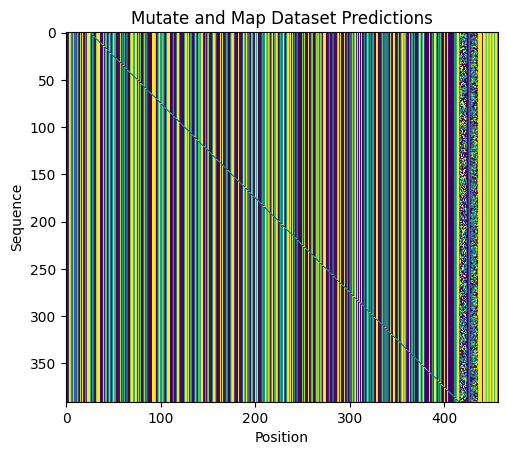

In [ ]:
# DMS MMAP
df_mmap_pred = df_mmap.str.split(pat="(?<=[AUGC])(?=[AUGC])", regex=True, expand=True)
df_mmap_pred[df_mmap_pred == "A"] = avg_react_A
df_mmap_pred[df_mmap_pred == "U"] = avg_react_U
df_mmap_pred[df_mmap_pred == "G"] = avg_react_G
df_mmap_pred[df_mmap_pred == "C"] = avg_react_C
df_mmap_pred = df_mmap_pred.astype("float")
plt.imshow(df_mmap_pred)
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

### Baseline 2.2

- Bound the reactivities in y_*_train between 0 and 1

- For A, U, G, and C, determine the average of all the bounded reactivities in y_*_train for the base

- Use the four averages to predict all the reactivities in y_*_test

In [ ]:
# 2A3 MAE
seq_mat_train = X_2A3_train.\
str.pad(width=206, side="right", fillchar="N").\
str.split(pat="(?<=[AUGCN])(?=[AUGCN])", n=205, expand=True)
seq_mat_train.columns = y_2A3_train.columns

avg_bnd_react_A = y_2A3_train[seq_mat_train=="A"].clip(0, 1).mean(axis=None).compute()
avg_bnd_react_U = y_2A3_train[seq_mat_train=="U"].clip(0, 1).mean(axis=None).compute()
avg_bnd_react_G = y_2A3_train[seq_mat_train=="G"].clip(0, 1).mean(axis=None).compute()
avg_bnd_react_C = y_2A3_train[seq_mat_train=="C"].clip(0, 1).mean(axis=None).compute()

seq_mat_test = X_2A3_test.\
str.pad(width=206, side="right", fillchar="N").\
str.split(pat="(?<=[AUGCN])(?=[AUGCN])", n=205, expand=True)
seq_mat_test.columns = y_2A3_test.columns

avg_bnd_react_AUGC = seq_mat_test
avg_bnd_react_AUGC[seq_mat_test=="A"] = avg_bnd_react_A
avg_bnd_react_AUGC[seq_mat_test=="U"] = avg_bnd_react_U
avg_bnd_react_AUGC[seq_mat_test=="G"] = avg_bnd_react_G
avg_bnd_react_AUGC[seq_mat_test=="C"] = avg_bnd_react_C
avg_bnd_react_AUGC[seq_mat_test=="N"] = np.nan
avg_bnd_react_AUGC = avg_bnd_react_AUGC.astype("float")

mean_absolute_error(y_2A3_test.clip(0, 1), avg_bnd_react_AUGC)

0.2811509228274641

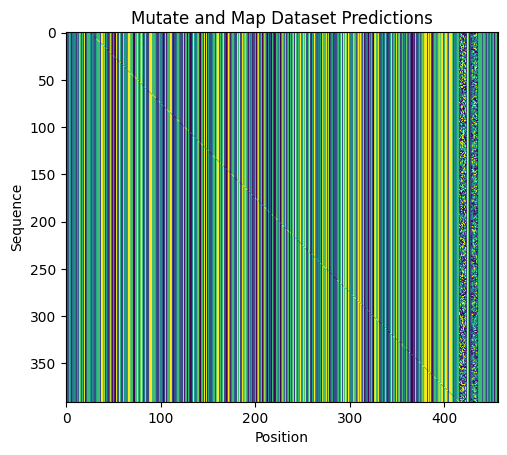

In [ ]:
# 2A3 MMAP
df_mmap_pred = df_mmap.str.split(pat="(?<=[AUGC])(?=[AUGC])", regex=True, expand=True)
df_mmap_pred[df_mmap_pred == "A"] = avg_bnd_react_A
df_mmap_pred[df_mmap_pred == "U"] = avg_bnd_react_U
df_mmap_pred[df_mmap_pred == "G"] = avg_bnd_react_G
df_mmap_pred[df_mmap_pred == "C"] = avg_bnd_react_C
df_mmap_pred = df_mmap_pred.astype("float")
plt.imshow(df_mmap_pred)
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

In [ ]:
# DMS MAE
seq_mat_train = X_DMS_train.\
str.pad(width=206, side="right", fillchar="N").\
str.split(pat="(?<=[AUGCN])(?=[AUGCN])", n=205, expand=True)
seq_mat_train.columns = y_DMS_train.columns

avg_bnd_react_A = y_DMS_train[seq_mat_train=="A"].clip(0, 1).mean(axis=None).compute()
avg_bnd_react_U = y_DMS_train[seq_mat_train=="U"].clip(0, 1).mean(axis=None).compute()
avg_bnd_react_G = y_DMS_train[seq_mat_train=="G"].clip(0, 1).mean(axis=None).compute()
avg_bnd_react_C = y_DMS_train[seq_mat_train=="C"].clip(0, 1).mean(axis=None).compute()

seq_mat_test = X_DMS_test.\
str.pad(width=206, side="right", fillchar="N").\
str.split(pat="(?<=[AUGCN])(?=[AUGCN])", n=205, expand=True)
seq_mat_test.columns = y_DMS_test.columns

avg_bnd_react_AUGC = seq_mat_test
avg_bnd_react_AUGC[seq_mat_test=="A"] = avg_bnd_react_A
avg_bnd_react_AUGC[seq_mat_test=="U"] = avg_bnd_react_U
avg_bnd_react_AUGC[seq_mat_test=="G"] = avg_bnd_react_G
avg_bnd_react_AUGC[seq_mat_test=="C"] = avg_bnd_react_C
avg_bnd_react_AUGC[seq_mat_test=="N"] = np.nan
avg_bnd_react_AUGC = avg_bnd_react_AUGC.astype("float")

mean_absolute_error(y_DMS_test.clip(0, 1), avg_bnd_react_AUGC)

0.21873748741375798

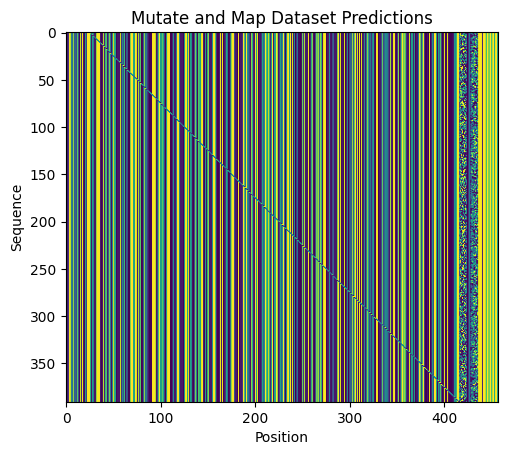

In [ ]:
# DMS MMAP
df_mmap_pred = df_mmap.str.split(pat="(?<=[AUGC])(?=[AUGC])", regex=True, expand=True)
df_mmap_pred[df_mmap_pred == "A"] = avg_bnd_react_A
df_mmap_pred[df_mmap_pred == "U"] = avg_bnd_react_U
df_mmap_pred[df_mmap_pred == "G"] = avg_bnd_react_G
df_mmap_pred[df_mmap_pred == "C"] = avg_bnd_react_C
df_mmap_pred = df_mmap_pred.astype("float")
plt.imshow(df_mmap_pred)
plt.title("Mutate and Map Dataset Predictions")
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fe343e39-d2c0-4296-915d-091d9a42752d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>